In [54]:
import os
import shutil
import platform
import subprocess
import zipfile
from PIL import Image
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import kaggle
import pennylane as qml
from pennylane import numpy as pnp
from pennylane.optimize import AdamOptimizer
from tqdm import trange
import matplotlib.pyplot as plt

Define the paths

In [2]:
kaggle_dir = ".kaggle/"
kaggle_json_path = ".kaggle/kaggle.json"
dataset_url = "danielbacioiu/tig-aluminium-5083"
base_dir = 'kaggle/datasets/al5083'

Kaggle setup

In [7]:
if not os.path.exists(kaggle_dir):
    os.makedirs(kaggle_dir)

shutil.move(kaggle_json_path, os.path.join(kaggle_dir, "kaggle.json"))

if platform.system() != 'Windows':
    os.chmod(kaggle_json_path, 0o600)
else:
    os.chmod(kaggle_json_path, 0o400)

print("Setup complete!")

Setup complete!


Download dataset

In [9]:
os.chmod(os.path.expanduser(".kaggle/kaggle.json"), 0o600)
subprocess.run(["kaggle", "datasets", "download", "-d", dataset_url])

print("Dataset download complete!")

Dataset download complete!


Unzip dataset

In [11]:
zip_file = None
for file in os.listdir('.'):
    if file.endswith(".zip"):
        zip_file = file
        break

if zip_file:
    zip_file_path = 'tig-aluminium-5083.zip'
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall('kaggle/datasets/')
    print("Dataset unzipped successfully!")
    os.remove(zip_file_path)
    print("Zip archive removed!")
else:
    print("No zip file found.")

Dataset unzipped successfully!
Zip archive removed!


Load and preprocess data

In [3]:
train_data_path = os.path.join(base_dir, 'train')
test_data_path = os.path.join(base_dir, 'test')

Load the data

In [4]:
def load_data(data_path, fraction=1.0):
    images = []
    labels = []
    for root, _, files in os.walk(data_path):
        if fraction < 1.0:
            files = np.random.choice(files, size=int(len(files) * fraction), replace=False)
        for file in files:
            if file.endswith(".png"):
                img_path = os.path.join(root, file)
                img = Image.open(img_path).convert('L')  # Convert to grayscale
                img = img.resize((28, 28))  # Resize for simplicity
                img = np.array(img).flatten()  # Flatten the image
                images.append(img)
                label = os.path.basename(root)
                labels.append(label)
    return np.array(images), np.array(labels)

Load only 1/3 of the data

In [5]:
X_train, y_train = load_data(train_data_path, fraction=1/3)
X_test, y_test = load_data(test_data_path, fraction=1/3)

Create a label map with all unique labels from both training and test sets

In [6]:
unique_labels = np.unique(np.concatenate((y_train, y_test)))
label_map = {label: idx for idx, label in enumerate(unique_labels)}

Encode the labels

In [7]:
y_train = np.array([label_map[label] for label in y_train])
y_test = np.array([label_map[label] for label in y_test])

Standardize the data

In [8]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Apply PCA to reduce dimensionality

In [9]:
num_qubits = 8  # Use 8 qubits for simplicity
pca = PCA(n_components=num_qubits)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

Split the training data for validation

In [10]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

Define the quantum device

In [11]:
dev = qml.device("default.qubit", wires=num_qubits)

Define the quantum circuit

In [19]:
def create_quantum_circuit():
    @qml.qnode(dev, interface='autograd')
    def quantum_circuit(inputs, weights):
        qml.templates.AngleEmbedding(inputs, wires=range(num_qubits))
        qml.templates.StronglyEntanglingLayers(weights, wires=range(num_qubits))
        return qml.expval(qml.PauliZ(0))
    return quantum_circuit

quantum_circuit = create_quantum_circuit()

Define the QNN

In [20]:
def qnn_model(weights, inputs):
    predictions = [quantum_circuit(x, weights) for x in inputs]
    return pnp.array(predictions)

Cost function

In [47]:
def cost(weights, inputs, labels):
    predictions = qnn_model(weights, inputs)
    return pnp.mean((predictions - labels)**2)

Initialize weights

In [48]:
num_layers = 6
weights = 0.01 * np.random.randn(num_layers, num_qubits, 3)

Optimizer

In [49]:
opt = qml.GradientDescentOptimizer(stepsize=0.1)
num_epochs = 10

Training

In [50]:
accuracy_list = []

for epoch in trange(num_epochs, desc="Training Progress"):
    weights, cost_val = opt.step_and_cost(lambda w: cost(w, X_train, y_train), weights)
    predictions = qnn_model(weights, X_val)
    acc = accuracy_score(y_val, predictions > 0.5)
    accuracy_list.append(acc)
    print(f"Epoch {epoch+1} - Cost: {cost_val:.4f} - Accuracy: {acc:.4f}")

Training Progress:  10%|█         | 1/10 [04:04<36:39, 244.38s/it]

Epoch 1 - Cost: 1103.0294 - Accuracy: 0.0434


c:\Users\max_h\anaconda3\envs\myenv_3_9\lib\site-packages\pennylane\_grad.py:157: UserWarning: Attempted to differentiate a function with no trainable parameters. If this is unintended, please add trainable parameters via the 'requires_grad' attribute or 'argnum' keyword.
  warnings.warn(
Training Progress:  20%|██        | 2/10 [08:21<33:34, 251.86s/it]

Epoch 2 - Cost: 1103.0294 - Accuracy: 0.0434


c:\Users\max_h\anaconda3\envs\myenv_3_9\lib\site-packages\pennylane\_grad.py:157: UserWarning: Attempted to differentiate a function with no trainable parameters. If this is unintended, please add trainable parameters via the 'requires_grad' attribute or 'argnum' keyword.
  warnings.warn(
Training Progress:  30%|███       | 3/10 [14:27<35:29, 304.18s/it]

Epoch 3 - Cost: 1103.0294 - Accuracy: 0.0434


c:\Users\max_h\anaconda3\envs\myenv_3_9\lib\site-packages\pennylane\_grad.py:157: UserWarning: Attempted to differentiate a function with no trainable parameters. If this is unintended, please add trainable parameters via the 'requires_grad' attribute or 'argnum' keyword.
  warnings.warn(
Training Progress:  40%|████      | 4/10 [18:26<27:49, 278.29s/it]

Epoch 4 - Cost: 1103.0294 - Accuracy: 0.0434


c:\Users\max_h\anaconda3\envs\myenv_3_9\lib\site-packages\pennylane\_grad.py:157: UserWarning: Attempted to differentiate a function with no trainable parameters. If this is unintended, please add trainable parameters via the 'requires_grad' attribute or 'argnum' keyword.
  warnings.warn(
Training Progress:  50%|█████     | 5/10 [22:32<22:13, 266.61s/it]

Epoch 5 - Cost: 1103.0294 - Accuracy: 0.0434


c:\Users\max_h\anaconda3\envs\myenv_3_9\lib\site-packages\pennylane\_grad.py:157: UserWarning: Attempted to differentiate a function with no trainable parameters. If this is unintended, please add trainable parameters via the 'requires_grad' attribute or 'argnum' keyword.
  warnings.warn(
Training Progress:  60%|██████    | 6/10 [51:58<51:46, 776.56s/it]

Epoch 6 - Cost: 1103.0294 - Accuracy: 0.0434


c:\Users\max_h\anaconda3\envs\myenv_3_9\lib\site-packages\pennylane\_grad.py:157: UserWarning: Attempted to differentiate a function with no trainable parameters. If this is unintended, please add trainable parameters via the 'requires_grad' attribute or 'argnum' keyword.
  warnings.warn(
Training Progress:  70%|███████   | 7/10 [56:25<30:30, 610.01s/it]

Epoch 7 - Cost: 1103.0294 - Accuracy: 0.0434


c:\Users\max_h\anaconda3\envs\myenv_3_9\lib\site-packages\pennylane\_grad.py:157: UserWarning: Attempted to differentiate a function with no trainable parameters. If this is unintended, please add trainable parameters via the 'requires_grad' attribute or 'argnum' keyword.
  warnings.warn(
Training Progress:  80%|████████  | 8/10 [1:00:49<16:39, 499.86s/it]

Epoch 8 - Cost: 1103.0294 - Accuracy: 0.0434


c:\Users\max_h\anaconda3\envs\myenv_3_9\lib\site-packages\pennylane\_grad.py:157: UserWarning: Attempted to differentiate a function with no trainable parameters. If this is unintended, please add trainable parameters via the 'requires_grad' attribute or 'argnum' keyword.
  warnings.warn(
Training Progress:  90%|█████████ | 9/10 [1:04:56<07:00, 420.66s/it]

Epoch 9 - Cost: 1103.0294 - Accuracy: 0.0434


c:\Users\max_h\anaconda3\envs\myenv_3_9\lib\site-packages\pennylane\_grad.py:157: UserWarning: Attempted to differentiate a function with no trainable parameters. If this is unintended, please add trainable parameters via the 'requires_grad' attribute or 'argnum' keyword.
  warnings.warn(
Training Progress: 100%|██████████| 10/10 [1:09:11<00:00, 415.14s/it]

Epoch 10 - Cost: 1103.0294 - Accuracy: 0.0434


Evaluate on test set

In [51]:

test_predictions = qnn_model(weights, X_test)
test_accuracy = accuracy_score(y_test, test_predictions > 0.5)
print(f"Test Accuracy: {test_accuracy:.4f}")

Test Accuracy: 0.0000


Identify defective parts

In [52]:

defective_indices = np.where(test_predictions > 0.5)[0]
non_defective_indices = np.where(test_predictions <= 0.5)[0]
print(f"Defective parts indices: {defective_indices}")
print(f"Non-defective parts indices: {non_defective_indices}")

Defective parts indices: [  23   30   72   75   77   80   92  106  114  195  198  204  210  211
  229  234  235  236  238  239  241  255  263  278  285  289  300  307
  315  317  322  325  326  347  348  352  355  370  388  397  405  419
  437  448  449  465  477  484  500  513  518  529  530  535  537  538
  547  548  605  615  616  617  640  641  661  664  667  690  691  708
  754  757  816  860  886  904  905  909  959  967  984  988  989 1003
 1010 1015 1029 1035 1064 1065 1066 1078 1083 1093 1096 1101 1107 1110
 1115 1161 1173 1182 1231 1243 1250 1266 1271 1275 1277 1301 1304 1317
 1329 1330 1344 1346 1361 1374 1382 1392 1396 1412 1414 1452 1478 1480
 1490 1514 1524 1538 1598 1619 1667 1756 1757 1779 1804 1805 1811 1821
 1822 1825 1839 1840 1848 1849 1853 1861 1871 1873 1876 1879 1886 1898
 1946 1955 1958 1990 1996 2039 2074 2080 2083 2087 2110 2180]
Non-defective parts indices: [   0    1    2 ... 2191 2192 2193]


Plotting Accuracy

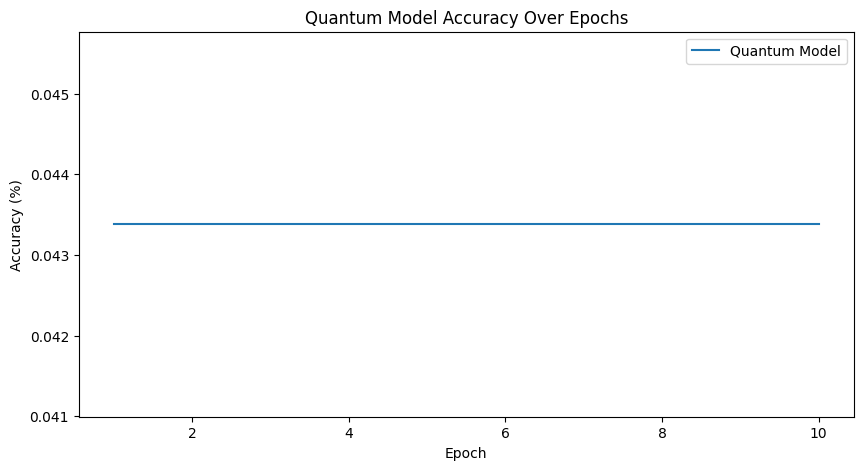

In [55]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), accuracy_list, label='Quantum Model')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Quantum Model Accuracy Over Epochs')
plt.legend()
plt.show()